# Figures for QPGA paper


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import qutip
import h5py

from qpga import *
from qpga.model import QPGA
from qpga.circuits import QFT, QFT_layer_count, cluster_state_generator
from qpga.training import *
from qpga.fidelity_search import *
from qpga.linalg import *
from qpga.plotting import *
from qpga.state_preparation import *
from qpga.callbacks import *
from qpga.utils import *

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
K.set_floatx('float64')

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Fidelity search plot

In [12]:
num_qubits = np.array([2,3,4,5])
num_layers_explicit = np.array([QFT_layer_count(n, nearest_neighbor_only=True, include_reshuffling=True) for n in num_qubits])
num_layers_SGD = [5, 7, 14, 33] 

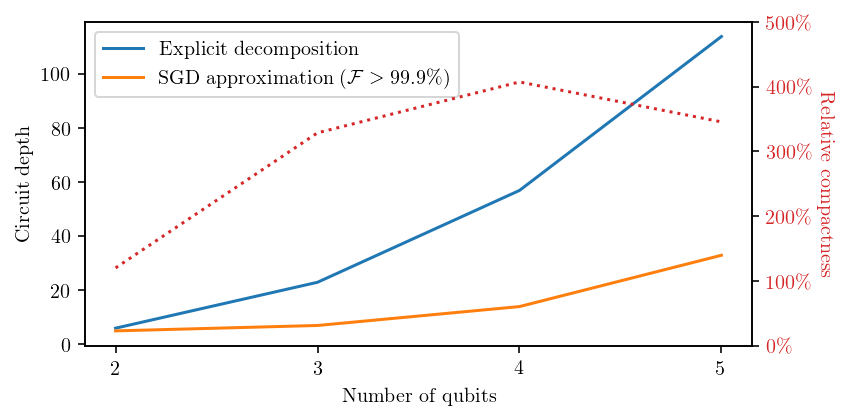

In [14]:
def plot_depth_search(num_qubits, num_layers_explicit, num_layers_SGD, savefig=False):
    
    i = len(num_layers_SGD)
    
    fig, ax1 = plt.subplots(figsize=(6,3))

    ax1.plot(num_qubits, num_layers_explicit, label="Explicit decomposition")
    ax1.plot(num_qubits[:i], num_layers_SGD, label="SGD approximation ($\mathcal{F} > 99.9\%$)")
    ax1.set_xlabel("Number of qubits")
    ax1.set_ylabel("Circuit depth")
    ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax1.legend()
    
    ax2 = ax1.twinx()
    
    color = 'tab:red'
    ax2.set_ylim([0, 5.0])
    ax2.set_ylabel("Relative compactness", color=color, rotation=270, labelpad=12.0)
    ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
    ax2.tick_params(axis='y', labelcolor=color)
    compactness = num_layers_explicit[:i] / num_layers_SGD
    ax2.plot(num_qubits[:i], compactness, color=color, linestyle=":")

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/circuit_depth.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
        
plot_depth_search(num_qubits, num_layers_explicit, num_layers_SGD, savefig=True)

## NOON state preparation training plot

In [10]:
N = 4
num_samples = 1

in_data = np_to_k_complex(np.array([zero_state(N)] * num_samples))
out_data = np_to_k_complex(np.array([noon_state(N)] * num_samples))

model = QPGA(N, 20).as_sequential()
model.compile(optimizer=Adam(lr=0.002), 
              loss=antifidelity, 
              metrics=[antifidelity])

callback = StatePreparationHistoryCallback(num_qubits=N, input_state = in_data[0:1], target_state = out_data[0:1])
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', 
                                                       factor = 0.25,
                                                       patience = 2,
                                                       verbose=1,
                                                       min_lr=1e-6)

history = model.fit(in_data, out_data, epochs=201, 
                    callbacks=[callback, reduce_lr_callback], verbose = 2)

Epoch 1/201
1/1 - 15s - loss: 0.9720 - antifidelity: 0.9720
Epoch 2/201
1/1 - 0s - loss: 0.9573 - antifidelity: 0.9573
Epoch 3/201
1/1 - 0s - loss: 0.9396 - antifidelity: 0.9396
Epoch 4/201
1/1 - 0s - loss: 0.9190 - antifidelity: 0.9190
Epoch 5/201
1/1 - 0s - loss: 0.8957 - antifidelity: 0.8957
Epoch 6/201
1/1 - 0s - loss: 0.8700 - antifidelity: 0.8700
Epoch 7/201
1/1 - 0s - loss: 0.8423 - antifidelity: 0.8423
Epoch 8/201
1/1 - 0s - loss: 0.8128 - antifidelity: 0.8128
Epoch 9/201
1/1 - 0s - loss: 0.7819 - antifidelity: 0.7819
Epoch 10/201
1/1 - 0s - loss: 0.7501 - antifidelity: 0.7501
Epoch 11/201
1/1 - 0s - loss: 0.7175 - antifidelity: 0.7175
Epoch 12/201
1/1 - 0s - loss: 0.6846 - antifidelity: 0.6846
Epoch 13/201
1/1 - 0s - loss: 0.6517 - antifidelity: 0.6517
Epoch 14/201
1/1 - 0s - loss: 0.6192 - antifidelity: 0.6192
Epoch 15/201
1/1 - 0s - loss: 0.5874 - antifidelity: 0.5874
Epoch 16/201
1/1 - 0s - loss: 0.5568 - antifidelity: 0.5568
Epoch 17/201
1/1 - 0s - loss: 0.5276 - antifidel

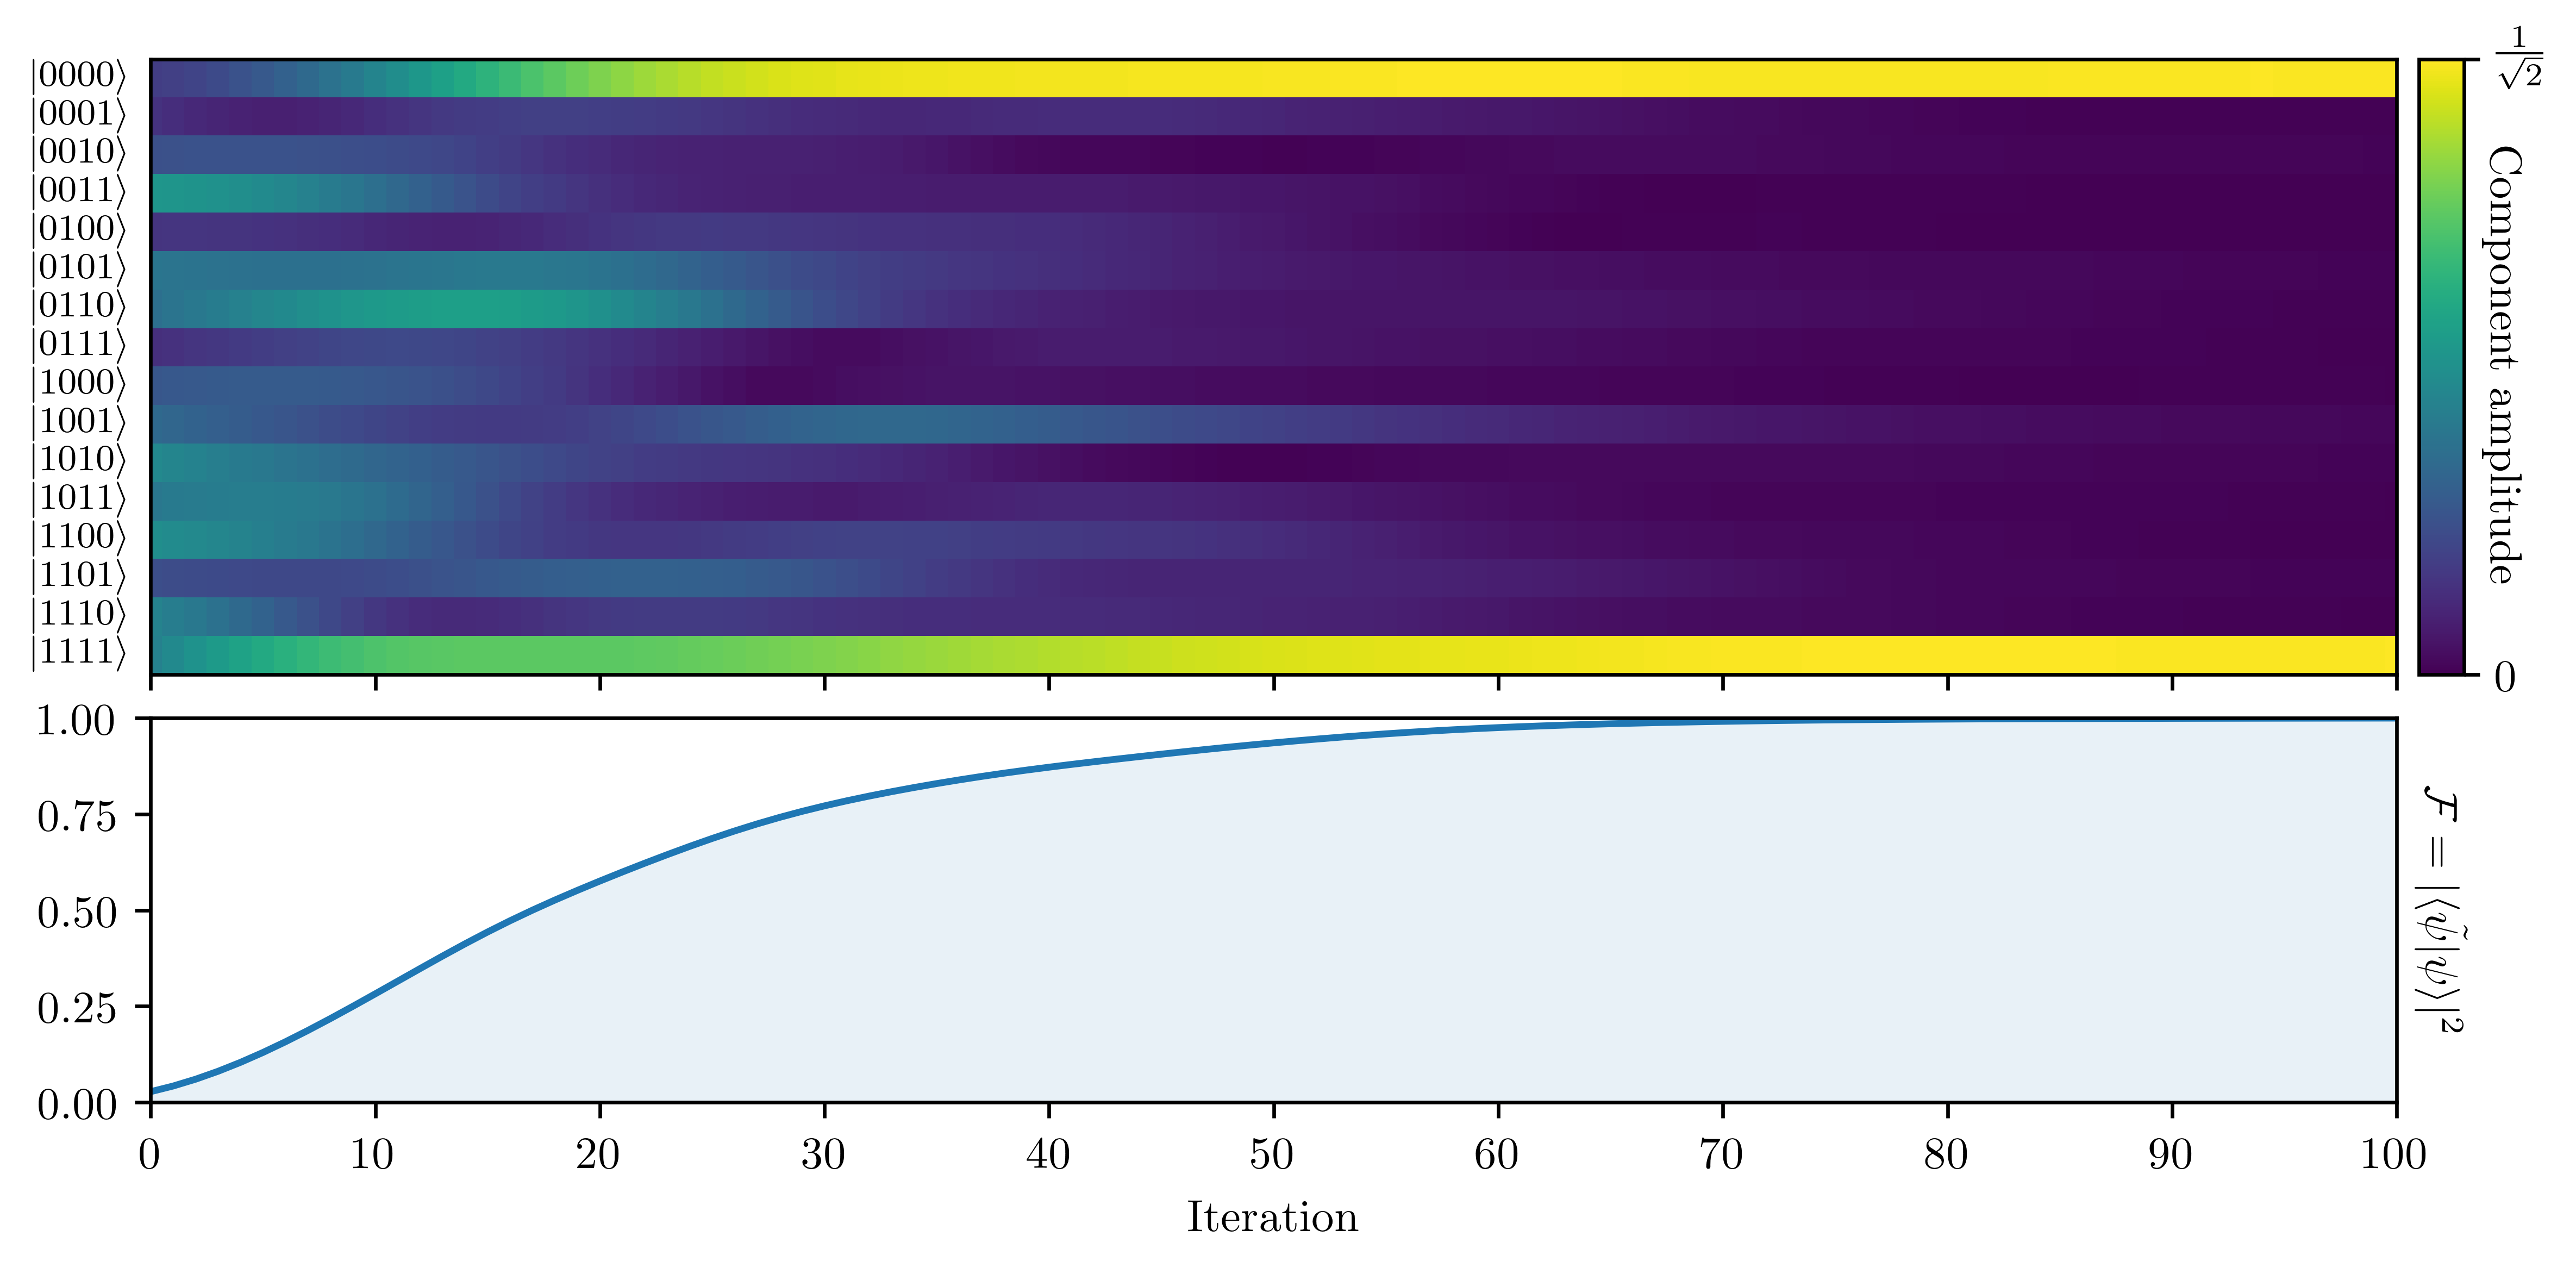

In [6]:
def plot_state_prep_training(filepath, max_epoch=None, savefig=False):
    
    f = h5py.File(filepath, 'r')
    
    input_state = np.array(f['input_state'])
    target_state = np.array(f['target_state'])
    output_states = np.array(f['output_states'])
    fidelities = np.array(f['fidelities'])
    
    output_states = k_to_np_complex(np.array(output_states)[:,0])
    
    if max_epoch is not None:
        output_states = output_states[:max_epoch]
        fidelities = fidelities[:max_epoch]
    
    kets = computational_basis_labels(N, include_bras=False)
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,4), gridspec_kw={'height_ratios': [2,1.25]}, sharex=True)

    # Plot state over training
    cmap='viridis'
    ax1.imshow(np.abs(np.transpose(output_states)), aspect='auto', cmap=cmap)
    ax1.set_xticks([])
    ax1.yaxis.set_major_locator(plt.IndexLocator(base=1, offset=0.35))
    ax1.yaxis.set_ticks_position('none')
    ax1.set_yticklabels(kets)
    ax1.tick_params(axis = 'y', labelsize = 8, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(0, 1/np.sqrt(2)),
                                     ticks = [0, np.sqrt(1/2)])
    cax.get_yaxis().labelpad=-4
    cax.set_ylabel("Component amplitude", rotation=270)
    cax.set_yticklabels(["$0$", "$\\frac{1}{\sqrt{2}}$"])
#     cax.text(0.5, 0.0, '$0$', transform = cax.transAxes, va = 'top', ha = 'center')
#     cax.text(0.5, 1.0, '$1/\sqrt{2}$', transform = cax.transAxes, va = 'bottom', ha = 'center')

    # Plot antifidelity
    loss_plot(fidelities, x_units='iterations', fig=fig, ax=ax2, ylabel="$\mathcal{F} = | \langle \\tilde{\psi} | \psi \\rangle |^2$", ylabel_pos='right')
    # Add a dummy axis to keep alignment
    divider = make_axes_locatable(ax2)
    dummyax = divider.append_axes('right', size = '2%', pad = '1%')
    dummyax.set_visible(False)
    
    fig.tight_layout(h_pad=0)
    
    # Save frame
    if savefig:
        plt.savefig("assets/noon_prep.pdf", dpi=300, bbox_inches='tight', pad_inches=0.025)
    else:
        plt.show()

plot_state_prep_training("./logs/state_history_4_qubits_2019.08.19.17.51.17.h5", max_epoch=101, savefig=True)

## Random state generation figure

In [15]:
N = 4

num_states_to_generate = 20

target_states = np.array([get_random_state_vector(N) for _ in range(num_states_to_generate)])

filename = "random_state_preparation_{}_qubits.h5".format(N)

for i in tqdm(range(num_states_to_generate)):

    in_data = np_to_k_complex(np.array([zero_state(N)] * 1))
    out_data = np_to_k_complex(np.array([target_states[i]] * 1))

    model = QPGA(N, 20).as_sequential()
    model.compile(optimizer=Adam(lr=0.01), 
                  loss=antifidelity, 
                  metrics=[antifidelity])

    callback = StatePreparationHistoryCallback(num_qubits = N, 
                                               input_state = in_data[0:1], 
                                               target_state = out_data[0:1],
                                               filename = filename,
                                               groupname = str(i))
    
    reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', 
                                                           factor = 0.25,
                                                           patience = 2,
                                                           verbose=0,
                                                           min_lr=1e-6)

    history = model.fit(in_data, out_data, epochs=101, 
                        callbacks=[callback, reduce_lr_callback], verbose = 0)

Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...
Writing data to random_state_preparation_4_qubits.h5...


W0913 12:49:46.531899 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (14.114006). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 12:51:27.938740 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (13.946497). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 12:53:15.356517 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (15.443210). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 12:55:10.797096 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (17.149635). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 12:57:34.382793 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (17.061403). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 12:59:42.175717 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (18.516836). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 13:01:52.350552 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (20.576682). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 13:04:41.018559 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (20.061487). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...


W0913 13:07:10.217306 4442961344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (25.278432). Check your callbacks.


Writing data to random_state_preparation_4_qubits.h5...



Mean final fidelity: 0.9922617312009543


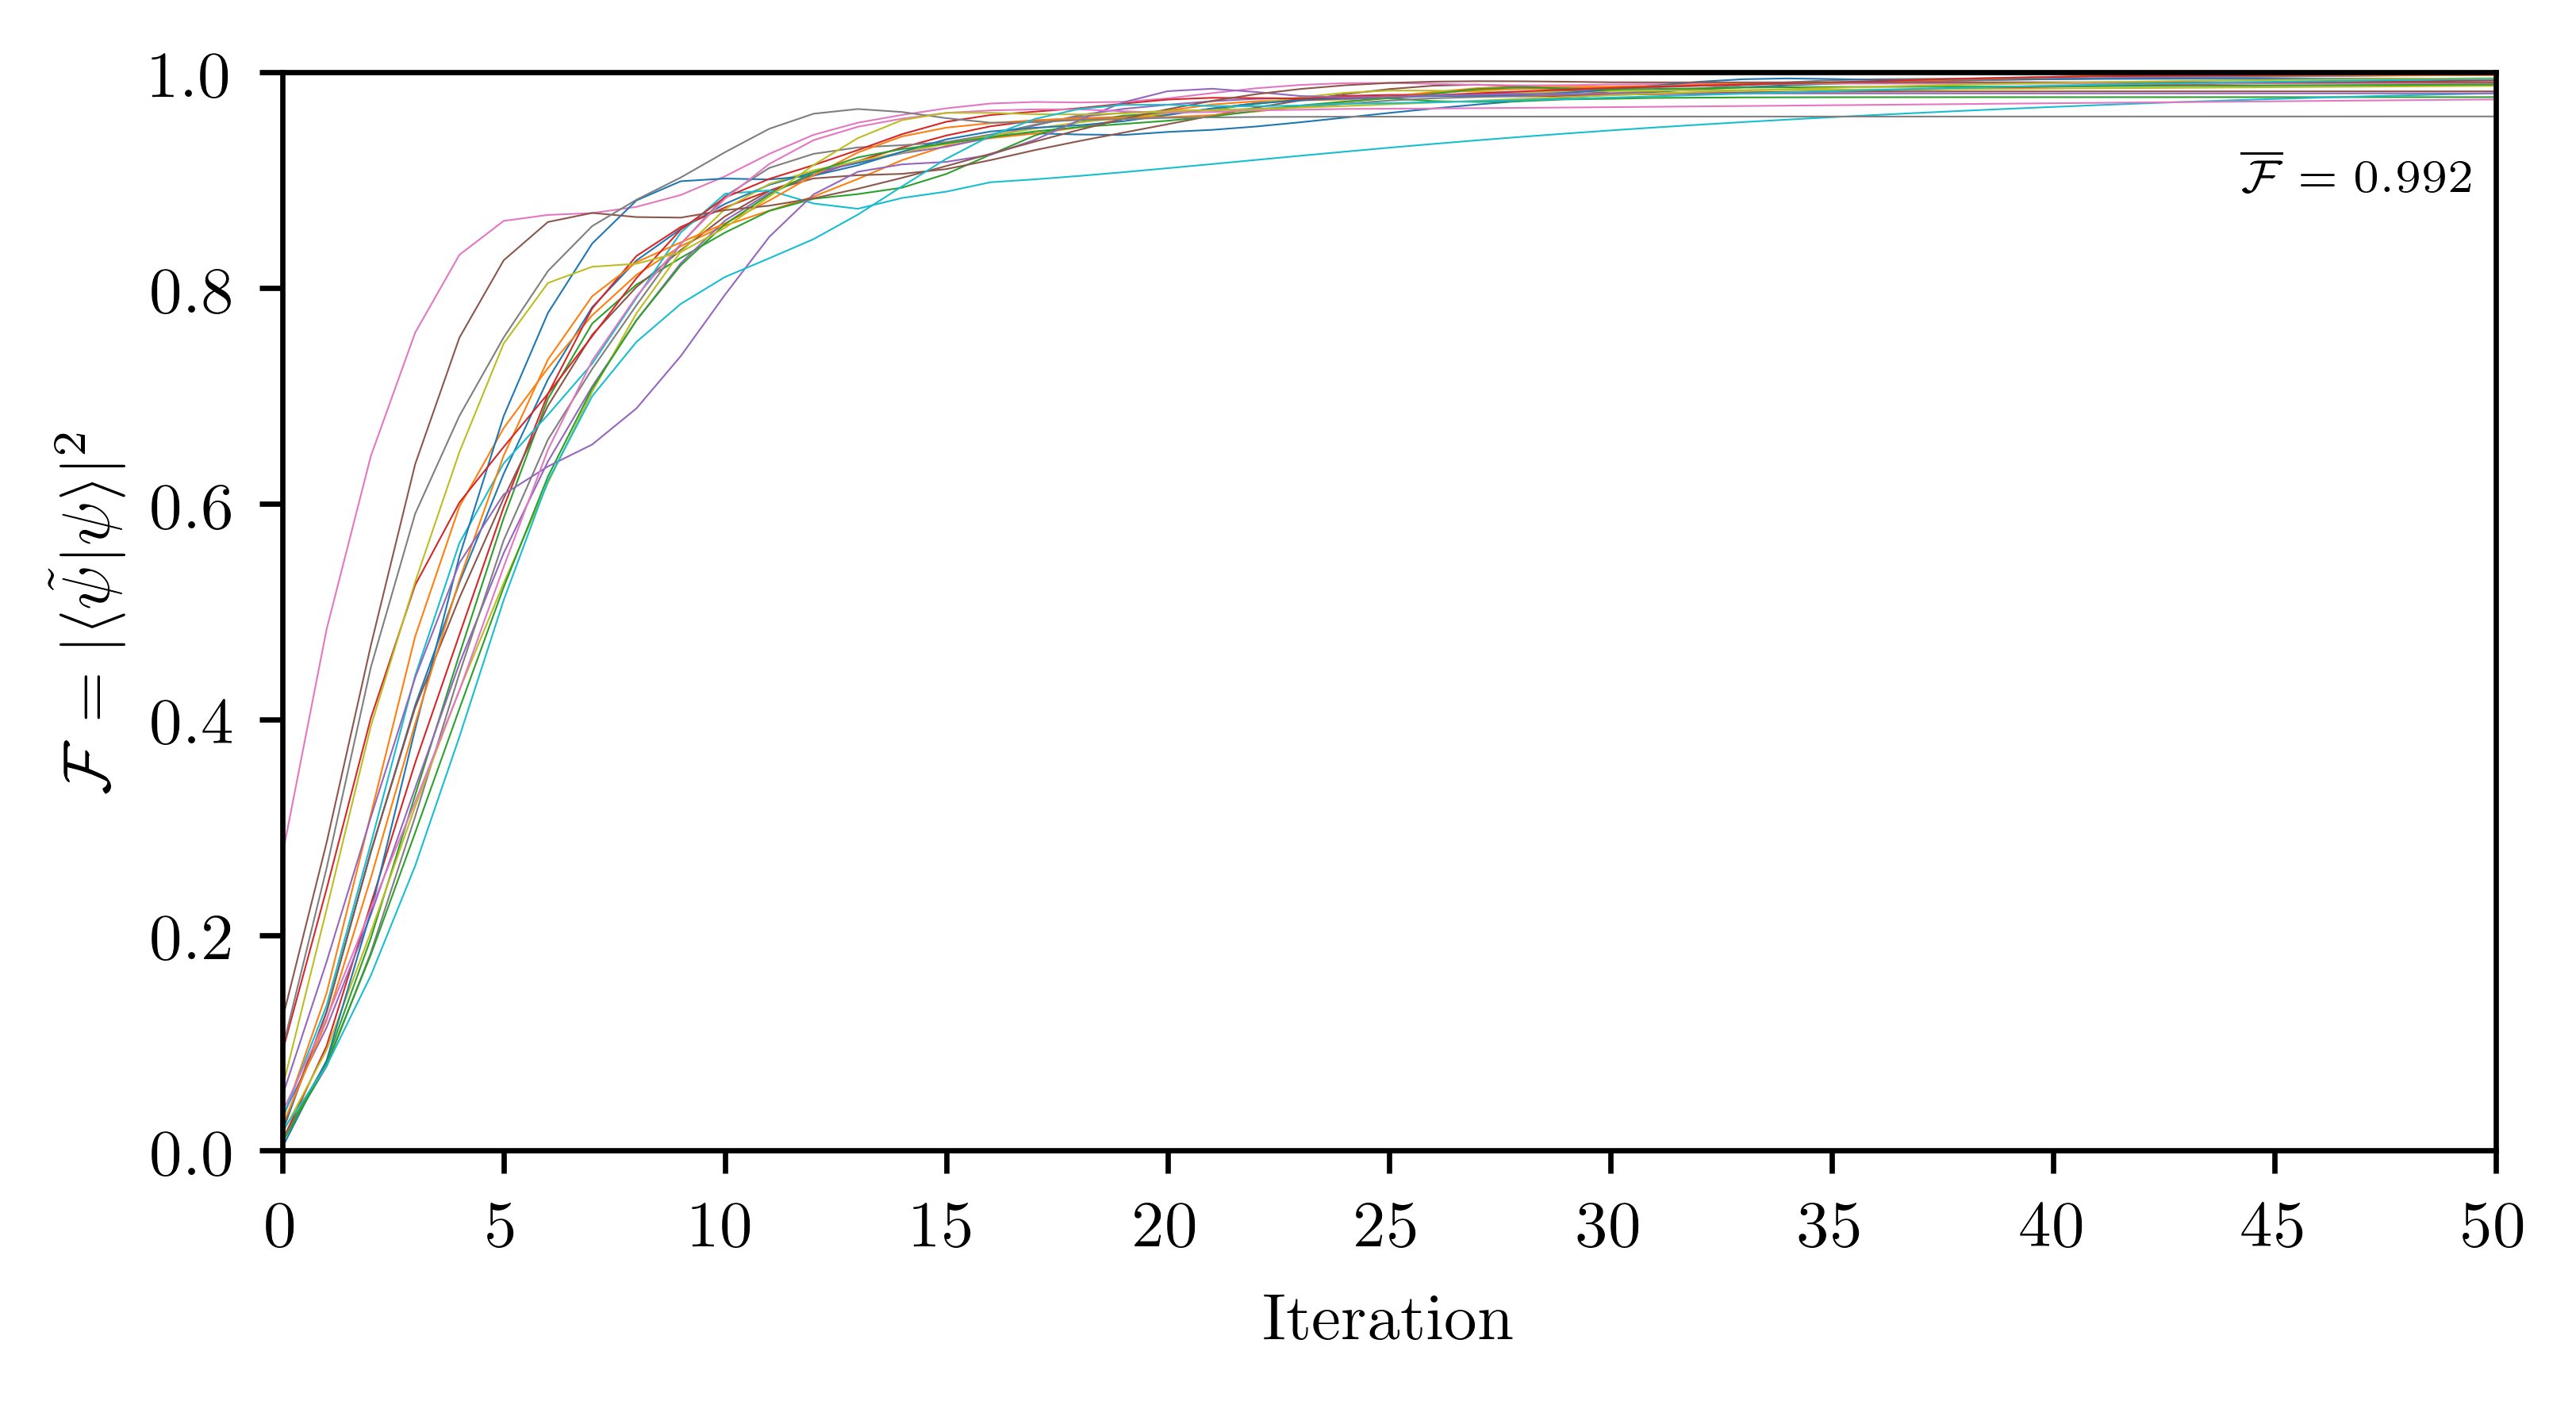

In [51]:
def plot_random_state_prep(filepath, max_epoch=None, log_fidelity=False, savefig=False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, ax = plt.subplots(1,1,figsize=(6,3))
    
    f = h5py.File(filepath, 'r')
    
    final_fidelities = []
    
    for group in f.keys():
        group = f[group]
        
        fidelities = np.array(group['fidelities'])

        final_fidelities.append(fidelities[-1])
        
        if max_epoch is not None:
            fidelities = fidelities[:max_epoch]

        ax.plot(fidelities, linestyle='-', linewidth=0.25)
        ax.set_xlim(0, len(fidelities)-1)

        
    ax.set_ylim(0, 1)
    ax.set_ylabel("$\mathcal{F} = | \langle \\tilde{\psi} | \psi \\rangle |^2$")

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xlabel("Iteration")
    
    plt.text(.99, 0.9, "$\overline{\mathcal{F}} = "+"{:.3f}".format(np.mean(final_fidelities))+"$", horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, 
             fontdict={"size":7, 
#                        "color":"grey"
                      })
        
    print("Mean final fidelity: {}".format(np.mean(final_fidelities)))
    
    # Save frame
    if savefig:
        plt.savefig("assets/random_state_prep.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
    else:
        plt.show()

plot_random_state_prep("./logs/random_state_preparation_4_qubits.h5", max_epoch=51, savefig=True)

## QFT plot

In [5]:
N = 5
in_data, out_data = prepare_training_data(QFT, N, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 769.62it/s]


In [9]:
model = QPGA(N, 200).as_sequential()
model.build(in_data.shape)
model.compile(optimizer = Adam(lr = 0.0001),
              loss = antifidelity,
              metrics = [antifidelity])

operator_vis = OperatorHistoryCallback(num_qubits=N, in_data=in_data, out_data=out_data)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.5,
                                              cooldown = 4,
                                              patience = 2,
                                              verbose = 1,
                                              min_lr = 1e-6)
callbacks = [operator_vis, reduce_lr]

history = model.fit(in_data, out_data,
                    epochs = 200,
                    validation_split = 0.1,
                    callbacks = callbacks,
                    verbose=1)

Train on 900 samples, validate on 100 samples
1000/1000 [==============================] - 71s 71ms/sample - loss: 0.9687 - antifidelity: 0.9687
Initial fidelity: [0.9686641327738762, 0.9686641327059634]
Epoch 1/200
900/900 [==============================] - 203s 226ms/sample - loss: 0.9678 - antifidelity: 0.9678 - val_loss: 0.9685 - val_antifidelity: 0.9685
Epoch 2/200
900/900 [==============================] - 17s 19ms/sample - loss: 0.9631 - antifidelity: 0.9631 - val_loss: 0.9644 - val_antifidelity: 0.9644
Epoch 3/200
900/900 [==============================] - 16s 18ms/sample - loss: 0.9551 - antifidelity: 0.9551 - val_loss: 0.9553 - val_antifidelity: 0.9553
Epoch 4/200
900/900 [==============================] - 14s 15ms/sample - loss: 0.9410 - antifidelity: 0.9410 - val_loss: 0.9375 - val_antifidelity: 0.9375
Epoch 5/200
900/900 [==============================] - 14s 16ms/sample - loss: 0.9194 - antifidelity: 0.9194 - val_loss: 0.9125 - val_antifidelity: 0.9125
Epoch 6/200
900/900

In [12]:
def plot_frames(filepath, num_qubits=N, num_epochs=None):
    
    f = h5py.File(filepath, 'r')
    
    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    
    num_epochs = len(fidelities_train) if num_epochs is None else num_epochs

    operator_targ = extract_operator_from_circuit(QFT, num_qubits)
    kets, bras = computational_basis_labels(num_qubits, include_bras=True)
    
    for i in pbar(range(num_epochs)):
        
        global_phase = np.mean(np.angle(operators[i]/operator_targ))
        operator = operators[i] / np.exp(1j * global_phase)

        # Make figure and axis layout
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig = plt.figure(figsize=(12,9), tight_layout=True)
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Plot operator visualizations
        hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
        hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

        # Plot antifidelity
        fidel_val = fidelities_val[0:i]
        fidel_train = fidelities_train[0:i]
        ax_bot = fig.add_subplot(gs[1, :])
        loss_plot(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot)

        # Save frame
        title = str(i).zfill(4)
        plt.savefig("assets/frames/qft_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [13]:
plot_frames('./logs/operator_history_5_qubits_2019.09.26.17.07.49.h5', num_qubits=5, num_epochs=151)

/Users/ben/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [2]:
# Define the nic_Edge cyclic colormap 

nic_edge_colors = np.array([
    [0.191208, 0.191208, 0.191208],
    [0.239484, 0.00545035, 0.614821],
    [0.220593, 0.0617459, 0.863547],
    [0.17509, 0.278988, 0.97794],
    [0.143526, 0.576069, 0.998553],
    [0.166456, 0.871883, 0.96594],
    [0.376202, 0.993555, 0.981833],
    [0.681996, 0.991297, 0.999239],
    [0.954172, 0.952734, 0.94374],
    [0.999735, 0.99301, 0.662896],
    [0.979399, 0.991466, 0.357973],
    [0.968771, 0.854967, 0.162659],
    [0.999245, 0.556697, 0.144323],
    [0.973959, 0.26223, 0.177946],
    [0.852358, 0.0526707, 0.222974],
    [0.593889, 0.00912724, 0.238855],
    [0.191208, 0.191208, 0.191208]
])
nic_edge = ListedColormap(nic_edge_colors)

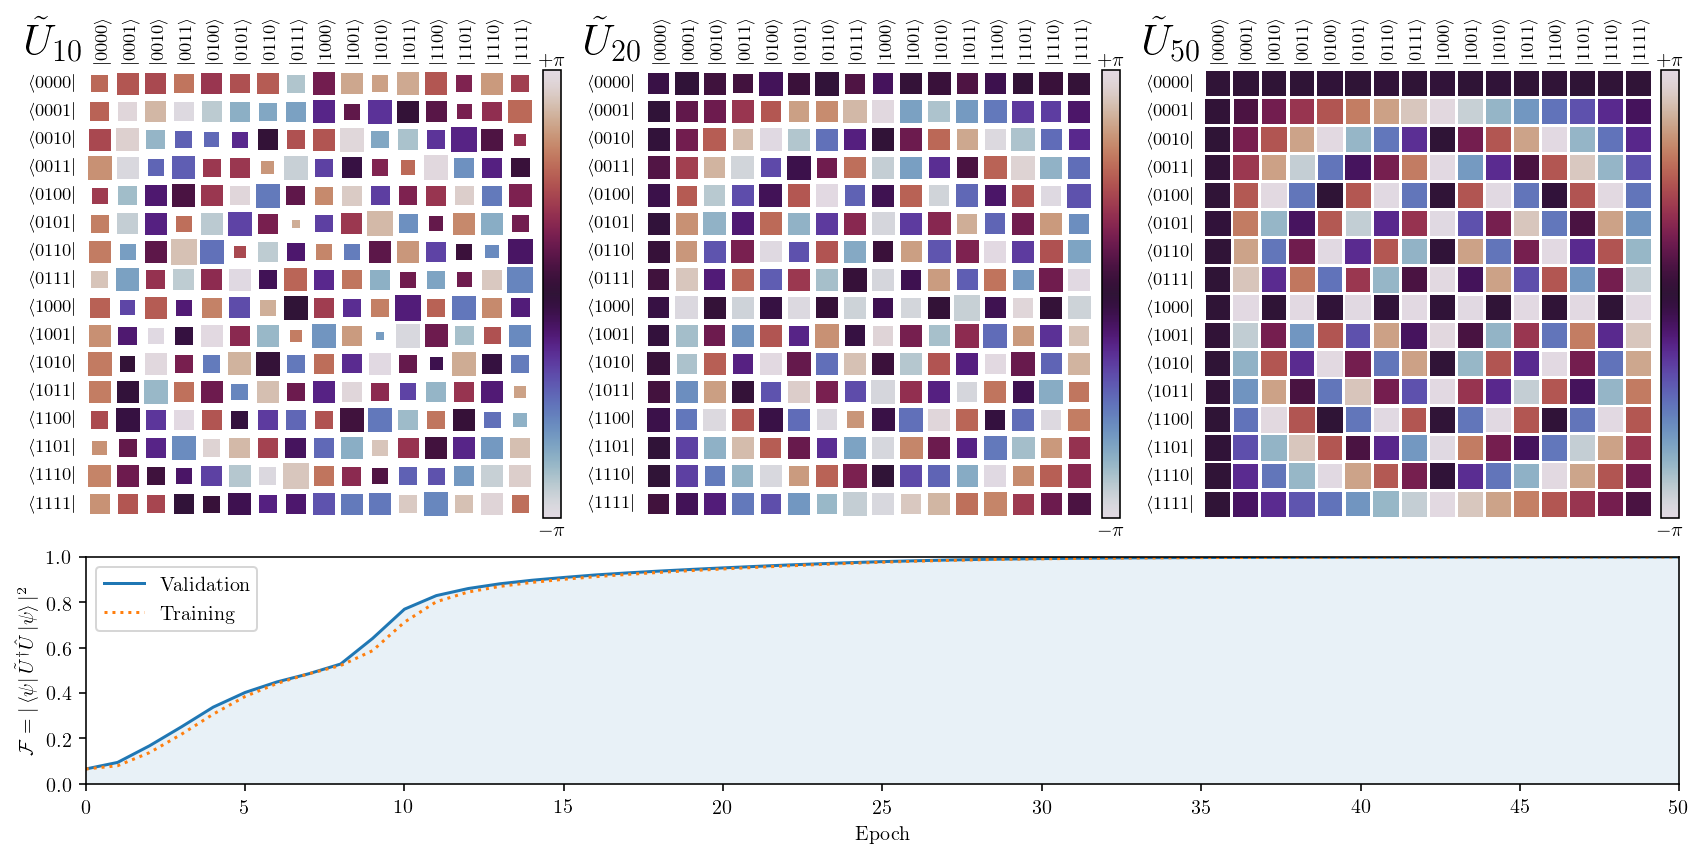

In [8]:
def plot_qft_figure(filepath, t1 = 0, t2 = 25, tmax = 50, figscale = 12, savefig = False):

    f = h5py.File(filepath, 'r')

    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    fidelity_init = 1 - np.array(f['fidelity_initial'])[-1]
    operator_init = np.array(f['operator_initial'])
    
    fidelities_val = np.insert(fidelities_val, 0, fidelity_init, axis=0)
    fidelities_train = np.insert(fidelities_train, 0, fidelity_init, axis=0)
    operators = np.insert(operators, 0, operator_init, axis=0)
    
    operator_targ = extract_operator_from_circuit(QFT, N)
    kets, bras = computational_basis_labels(N, include_bras=True)

    global_phase1 = np.mean(np.angle(operators[t1]/operator_targ))
    operator1 = operators[t1] / np.exp(1j * global_phase1)

    global_phase2 = np.mean(np.angle(operators[t2]/operator_targ))
    operator2 = operators[t2] / np.exp(1j * global_phase2)
    
    global_phase3 = np.mean(np.angle(operators[tmax]/operator_targ))
    operator3 = operators[tmax] / np.exp(1j * global_phase3)

    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(figscale, figscale*(1/3 + 1/6)), tight_layout=True)
    gs = mpl.gridspec.GridSpec(2, 3, height_ratios = [2, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Plot antifidelity
    fidel_val = fidelities_val[0:tmax+1]
    fidel_train = fidelities_train[0:tmax+1]
    ax_bot = fig.add_subplot(gs[1, :])
    loss_plot(fidel_val, fidel_train, x_units='epochs', x_max = tmax+1, fig=fig, ax=ax_bot, log_fidelity=False)

    # Plot operator visualizations
    fidel1 = fidel_val[t1]
    hinton(operator1, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}_{"+str(t1)+"}$")
    
    fidel2 = fidel_val[t2]
    hinton(operator2, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\\tilde{U}_{"+str(t2)+"}$")
    
    fidel_3 = fidel_val[tmax]
    hinton(operator3, xlabels=kets, ylabels=bras, fig=fig, ax=ax3, title="$\\tilde{U}_{"+str(tmax)+"}$")

    if savefig:
        plt.savefig("assets/qft_3panel.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    
plot_qft_figure('logs/operator_history_4_qubits_2019.08.27.11.03.16.h5', t1=10, t2=20, tmax=50, savefig=False)

In [1]:
in_data, out_data = prepare_training_data(cluster_state_generator, 9, 10)

NameError: name 'prepare_training_data' is not defined

## MZI self-interference

In [50]:
def gaussian(omegas, sigma, omega0 = 0.0):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(omegas - omega0)**2 / (2 * sigma**2))

In [51]:
H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]], dtype = np.complex128)
BS = 1 / np.sqrt(2) * np.array([[1 + 0j, 0 + 1j], [0 + 1j, 1 + 0j]], dtype = np.complex128)

In [52]:
class MZI_single_photon:
    def __init__(self, tau):
        self.tau=tau
    
    def call(self, x):
        a1, a2 = x
        
        # Hadamard op
        a1, a2 = np.dot(H, np.array([a1, a2]))
        
        # Phase shift in frequency space
        a1 = a1 * np.exp(1j * omegas * self.tau)
        
        # Hadamard op
        a1, a2 = np.dot(H, np.array([a1, a2]))
        
        # Phase shift in frequency space
        a1 = a1 * np.exp(1j * omegas * self.tau)
        
        return np.array([a1, a2])

In [53]:
n_omega = 999
omega0 = 1e12
sigma = 1e10
omegas = np.linspace(omega0-5*sigma, omega0+5*sigma, n_omega)
phi = np.reshape(gaussian(omegas, sigma, omega0=omega0), (n_omega, 1))

In [54]:
mzi = MZI_single_photon(np.pi/omega0)
psi_in = np.transpose(phi * (np.array([1, -1]) / np.sqrt(2)))
psi_out = mzi.call(psi_in)

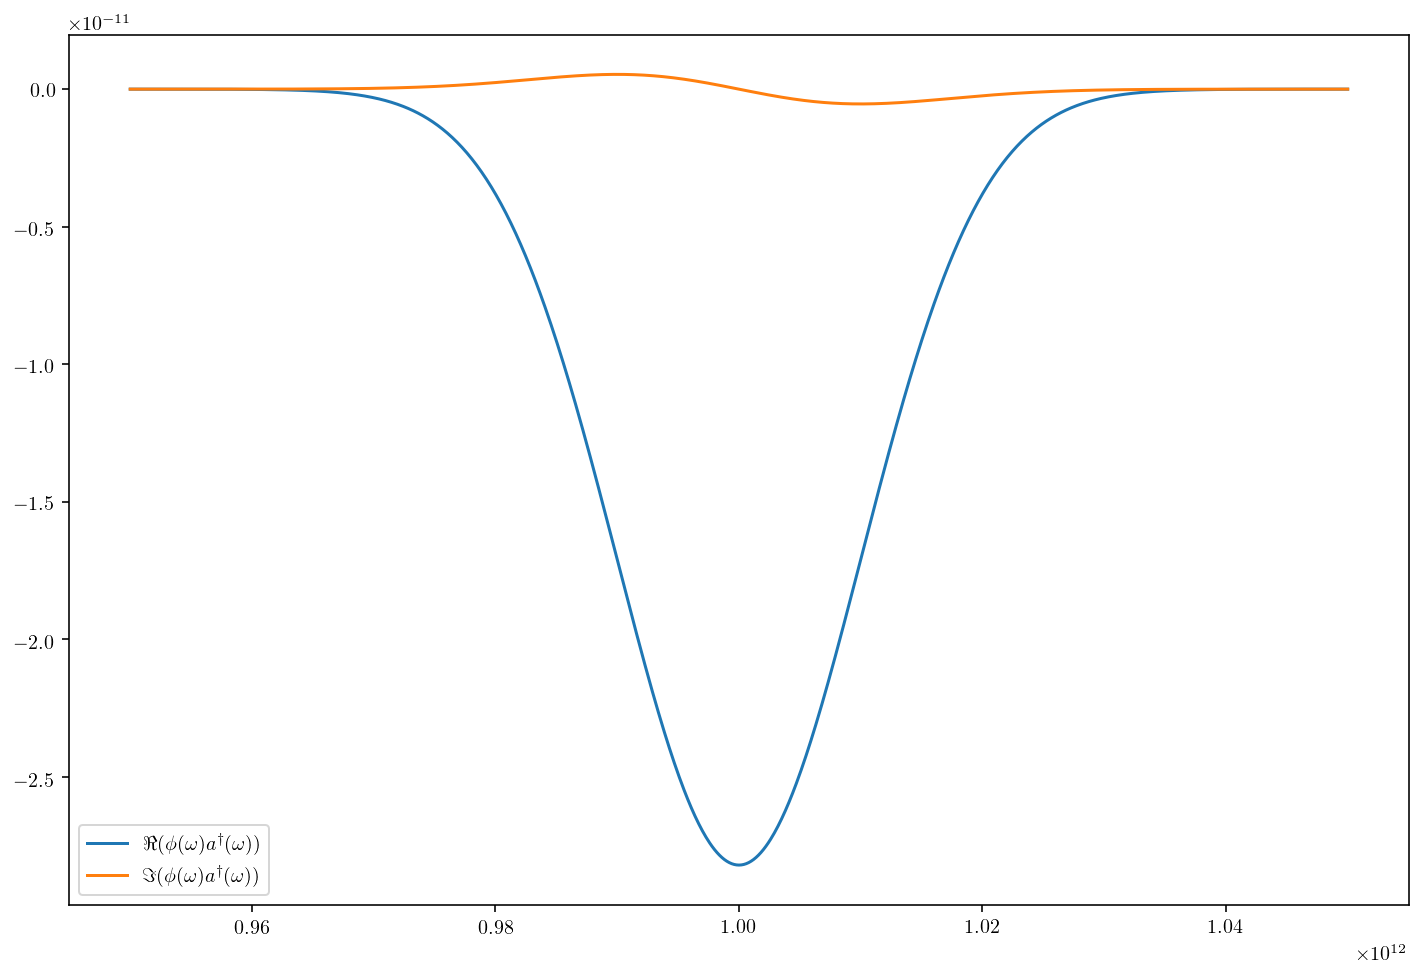

In [55]:
# fix, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12,8))
plt.figure(figsize=(12,8))
plt.plot(omegas, np.real(psi_out[0]), label="$\Re (\phi(\omega) a^\dagger(\omega))$")
plt.plot(omegas, np.imag(psi_out[0]), label="$\Im (\phi(\omega) a^\dagger(\omega))$")
plt.legend()
plt.show()

In [21]:
psi_out[1]

array([9.404e-29+5.420e-28j, 1.469e-14-4.628e-13j, 9.580e-14-1.507e-12j, 3.476e-13-3.640e-12j, 9.857e-13-7.724e-12j, 2.430e-12-1.519e-11j, 5.463e-12-2.834e-11j, 1.148e-11-5.083e-11j, 2.290e-11-8.826e-11j, 4.378e-11-1.491e-10j, 8.078e-11-2.459e-10j, 1.445e-10-3.969e-10j, 2.514e-10-6.280e-10j,
       4.267e-10-9.751e-10j, 7.081e-10-1.488e-09j, 1.150e-09-2.231e-09j, 1.832e-09-3.293e-09j, 2.864e-09-4.783e-09j, 4.397e-09-6.842e-09j, 6.637e-09-9.640e-09j, 9.854e-09-1.338e-08j, 1.440e-08-1.831e-08j, 2.072e-08-2.469e-08j, 2.936e-08-3.282e-08j, 4.101e-08-4.301e-08j, 5.645e-08-5.556e-08j,
       7.661e-08-7.076e-08j, 1.025e-07-8.884e-08j, 1.353e-07-1.100e-07j, 1.763e-07-1.342e-07j, 2.265e-07-1.613e-07j, 2.873e-07-1.911e-07j, 3.595e-07-2.231e-07j, 4.442e-07-2.565e-07j, 5.418e-07-2.903e-07j, 6.524e-07-3.233e-07j, 7.756e-07-3.542e-07j, 9.106e-07-3.814e-07j, 1.056e-06-4.033e-07j,
       1.209e-06-4.183e-07j, 1.367e-06-4.250e-07j, 1.526e-06-4.220e-07j, 1.684e-06-4.084e-07j, 1.834e-06-3.838e-07j, 1.97

## MZI fidelity

In [57]:
# copied from mathematica output
mins, means, maxes, dTlist = [[0.9999999997814122,0.9999999997657385,0.9999999997553899,0.9999999997440789,0.9999999996725557,0.9999999996821307,0.9999999995840114,0.999999999531819,0.9999999994834645,0.9999999994085402,0.9999999993643298,0.9999999992469342,0.9999999992363611,0.9999999990525668,0.9999999990028035,0.999999998699806,0.9999999985743435,0.9999999983734307,0.9999999983861594,0.9999999982773329,0.9999999976340339,0.999999997800278,0.9999999973569691,0.9999999971186628,0.9999999963740824,0.9999999964489161,0.9999999956128693,0.9999999951307086,0.9999999945163864,0.9999999932417833,0.9999999926317957,0.9999999919379414,0.9999999912571615,0.9999999895104512,0.9999999885816111,0.9999999892578981,0.999999985707281,0.9999999854117387,0.999999981732348,0.9999999822557745,0.9999999787102009,0.9999999733206566,0.9999999730739144,0.999999970525896,0.9999999641128942,0.999999961502413,0.9999999575957943,0.9999999503851502,0.9999999457468677,0.9999999356445995,0.9999999346400483,0.9999999186422192,0.9999999176487914,0.9999999043571527,0.9999999000848996,0.9999998790838079,0.9999998628350137,0.9999998436986733,0.9999998276401768,0.9999998108399631,0.9999997744110608,0.9999997367986011,0.9999997281390225,0.9999996685874545,0.999999699916612,0.9999995791914004,0.9999995724614772,0.9999994996433488,0.9999994706016898,0.9999994418716142,0.9999992369600751,0.9999992702544572,0.9999990145381895,0.9999989959319608,0.999998810121161,0.999998769697588,0.9999985487487967,0.9999983583489828,0.9999983596576333,0.9999980198823416,0.9999976256260611,0.9999975510437288,0.9999970587607798,0.9999967453430453,0.9999966492331176,0.9999962681985576,0.9999950782569401,0.9999952342147173,0.999994681109652,0.999993542003807,0.9999929627538948,0.9999917900819484,0.9999900187368918,0.9999897402559587,0.9999893649138224,0.9999873573284452,0.9999870536553608,0.9999843754485308,0.9999820026610575,0.9999811105867642,0.9999754681828317,0.999973968627077,0.9999702540900045,0.9999701108332112,0.9999655258227571,0.9999546559739171,0.9999518234192738,0.9999474758429733,0.9999412565406918,0.9999318124409996,0.9999212490860586,0.9999208660765434,0.999911678915575,0.9998969946774909,0.9998961433209793,0.9998752164159581,0.9998534863286004,0.999840689757182,0.9998141099086754,0.9997978261475381,0.999782380340272,0.9997629397622544,0.9997194399252433,0.9996822322380664,0.9996579282726215,0.9996192796232635,0.9995143807571485,0.9994813782257147,0.9994204980062091,0.9993623687669575,0.999259358590936,0.999204945756033,0.9990222486771199,0.9989544408007756,0.9988588925289957,0.9987453625633592,0.9986369704250689,0.9985091771717607,0.9982642138858097,0.9980664936823564,0.9974715856568698,0.9975090426570377,0.997207206693087,0.9969740128253015,0.9964689098977211,0.9959057173600588,0.9951694931662303,0.9947085818386616,0.9943121647307822,0.9934428633280936,0.9922938873332069,0.9921420675718045,0.9906845711644237,0.9896922220614027,0.9873124513252589,0.9864585469834167,0.9857804044487853,0.9823761394065517,0.9818238662824343,0.9792616453094946,0.9745395693592193,0.9762715128905718,0.9705717955344475,0.9655907423377705,0.96837737251582,0.9573137369767911,0.9593152752523421,0.9492406417901268,0.9411373455534228,0.9404131973749991,0.9346856219731933,0.9251002072651576,0.9085667489174075,0.9018798489674689,0.891986164625019,0.8787136496304688,0.8614977502650258,0.8553236313499928,0.82657434228339,0.793590567035433,0.8024552994233767,0.7562185271432691,0.772290734610493,0.710062643830522,0.680553509249187,0.6577404133871345,0.6239977690122896,0.6382785620225584,0.6071543499873473,0.49211339262127163,0.4799814518157115,0.468329198668031,0.3916744496034218,0.4079114582692841,0.34223824302667766,0.3032395256668304,0.22499679717940785,0.19941253117999147,0.16136998146745984,0.10694946053640386],[0.9999999999532118,0.9999999999424511,0.9999999999444793,0.9999999999437528,0.9999999999204485,0.9999999999283995,0.9999999999013889,0.9999999998927258,0.9999999998828912,0.9999999998579325,0.9999999998333664,0.9999999998211875,0.9999999998034717,0.9999999997738079,0.9999999997281204,0.9999999997070865,0.9999999996828511,0.9999999996340705,0.9999999995988612,0.9999999995424447,0.999999999459089,0.9999999994377232,0.9999999993608688,0.9999999992522471,0.9999999991775962,0.9999999990864779,0.9999999989858244,0.9999999988698206,0.9999999986665102,0.9999999985528839,0.9999999983329905,0.999999998145726,0.9999999979013258,0.9999999976350565,0.9999999974241971,0.9999999970356218,0.9999999968215562,0.9999999962375558,0.9999999958139818,0.999999995333977,0.9999999947806696,0.9999999943258172,0.9999999933335428,0.9999999926114401,0.9999999914345856,0.9999999905751451,0.9999999895159619,0.9999999881533702,0.9999999868264363,0.9999999853770348,0.9999999847823833,0.9999999817153874,0.9999999795221427,0.9999999763875618,0.9999999737936898,0.999999970368074,0.9999999667082589,0.9999999633617649,0.9999999585977682,0.9999999525307869,0.9999999469730169,0.9999999410014039,0.999999932078029,0.9999999238244275,0.9999999186516356,0.9999999063812766,0.9999998958632773,0.9999998804732106,0.9999998699920103,0.9999998538105301,0.9999998297093801,0.999999810575814,0.9999997949869016,0.9999997632737769,0.9999997379806959,0.9999996992516844,0.9999996525084959,0.9999996348539973,0.9999995654436814,0.9999995350516678,0.9999994553826188,0.9999993981394171,0.999999308026319,0.9999992388005806,0.99999918077091,0.9999990606308253,0.9999989057878597,0.9999988005686361,0.999998720138092,0.9999985468570725,0.999998284074182,0.9999980317535482,0.9999978474697812,0.9999975266325941,0.9999973072379994,0.9999970549598111,0.999996593259791,0.9999960178499523,0.9999956853885988,0.9999952553325974,0.9999945462290482,0.9999939267687253,0.9999929580233488,0.9999922857350896,0.999991384035834,0.9999903343083498,0.9999892947959204,0.99998790554328,0.9999864081354057,0.9999852002441001,0.9999823609714301,0.9999806826165208,0.9999780911454702,0.9999745386398083,0.9999726544949852,0.9999697611370534,0.9999656791944228,0.9999609102226382,0.9999565704933417,0.9999492342460068,0.9999475135125465,0.9999392359875553,0.9999321124426748,0.9999232564824443,0.9999136603497846,0.9999045961705485,0.9998863415317105,0.9998761841043956,0.9998635280286345,0.9998454857135896,0.9998270496069476,0.9998117313227431,0.9997778321558786,0.9997504609823958,0.9997230332102512,0.9996866169464171,0.9996632103230864,0.9996188022175035,0.9995626851657612,0.9995141882575017,0.9994491649194519,0.99938036783909,0.9993067177166436,0.9992008949276758,0.9991445468881044,0.9989984274827227,0.9989324541608698,0.9987153100634694,0.9985975686012368,0.9983638803767373,0.9982150178904988,0.9980428642022846,0.9977777543616941,0.9974597080383001,0.9972466143869524,0.9969225562662898,0.9965149588819869,0.9960729161458326,0.9954252377989106,0.9951849904731648,0.9946658590045252,0.9938714774175256,0.9929491438707078,0.9921347680371283,0.9912448952892651,0.9900974953625314,0.9892615073190753,0.9875959640232049,0.9864506679234019,0.9845166444517089,0.9822502673578278,0.9808544294953987,0.977340005629799,0.9739675158915406,0.9728120865781514,0.969386668062851,0.9669707735925896,0.9607571355311371,0.9565398012652963,0.952167576853597,0.9468954053286657,0.9397840993443265,0.9319488370972349,0.9229216221556508,0.9133013703521192,0.9059272165605077,0.8958301408164332,0.884167653734434,0.8770991313393894,0.8589549548762881,0.8416466615294068,0.8312862716813654,0.8165088324380476,0.7895122852803031,0.7682614025518674,0.7474585201909256,0.7279441746111058,0.7055872977938177,0.6775059298759342,0.6456391010521361],[1.0000000000047957,1.0000000000003326,1.0000000000054343,1.0000000000126956,0.99999999999612,1.0000000000121956,0.9999999999955025,1.0000000000008908,0.9999999999986326,1.0000000000015024,0.9999999999876095,1.0000000000010054,1.000000000005548,0.9999999999935911,0.99999999998581,0.9999999999967624,0.9999999999919349,0.9999999999757647,0.9999999999917726,0.9999999999959976,0.9999999999835121,0.9999999999700919,0.9999999999891098,0.9999999999406439,0.9999999999604126,0.9999999999412883,0.9999999999095057,0.9999999999776317,0.9999999999082494,0.999999999980639,0.9999999999712113,0.999999999907726,0.9999999999250782,0.9999999998364151,0.9999999998389741,0.9999999999178675,0.9999999999562379,0.9999999999351676,0.9999999997709454,0.9999999999158777,0.9999999998766862,0.9999999999124678,0.9999999995738342,0.9999999996890025,0.9999999996128521,0.9999999995309024,0.9999999995672844,0.9999999997509239,0.9999999992793542,0.9999999995523812,0.9999999993497997,0.9999999986636694,0.9999999992551021,0.9999999993047313,0.9999999986885084,0.999999998896568,0.9999999993909574,0.9999999981103076,0.9999999983792693,0.9999999975106126,0.9999999976470204,0.9999999970352649,0.9999999956510917,0.9999999987114516,0.9999999973373845,0.9999999936592592,0.9999999922924063,0.9999999927011727,0.9999999966942896,0.9999999878546499,0.9999999970446973,0.9999999932409844,0.9999999978228356,0.9999999871422507,0.9999999841429764,0.9999999908466242,0.999999987308767,0.9999999902719527,0.9999999660453892,0.9999999845369346,0.9999999853501742,0.9999999803093168,0.9999999590190203,0.9999999760535349,0.9999999764497062,0.9999999734723286,0.999999984693528,0.9999999198756919,0.9999999715036438,0.9999999527625586,0.9999999218304372,0.9999999738277554,0.9999998925258333,0.9999999196389208,0.9999998522154724,0.9999998466757128,0.9999998925248976,0.9999998824822337,0.9999998385401624,0.9999997504035929,0.9999997095783895,0.9999997039620171,0.999999780774874,0.9999997217055523,0.9999995831097835,0.9999997168401226,0.9999994979546578,0.9999995885438006,0.9999996381623834,0.999999564694051,0.999999320898185,0.9999992141383359,0.9999988692109011,0.9999986126513192,0.9999993184780716,0.9999996831740074,0.999999167461831,0.9999977545676693,0.9999980792945732,0.9999969859011916,0.9999968165019274,0.9999969934854778,0.9999952904059108,0.9999957489663379,0.9999974188689513,0.9999986753345157,0.9999936703124334,0.9999932085136994,0.9999954682161342,0.9999957011508147,0.9999946817976553,0.9999897065120139,0.9999944656508434,0.9999935282535026,0.9999880553087978,0.999993514307177,0.9999819974564592,0.9999735156649583,0.9999821286736839,0.9999825651390791,0.9999933654172971,0.9999933730076563,0.9999719997679825,0.9999774455603148,0.9999475861323109,0.9999577152486956,0.999932410805726,0.9999186930267648,0.9999254654879381,0.9999503095876167,0.999939709060743,0.9999385299375925,0.999946938722274,0.9998505361564838,0.9998727756255092,0.999955730429893,0.9999089658142292,0.9998249430169265,0.9999076870792226,0.9998798048959489,0.9998268713952878,0.9999043328556609,0.9997203937372717,0.9994904861538393,0.9993007542312786,0.9999237246156057,0.9997943239417191,0.9994746037662536,0.99945492240118,0.9997321375505799,0.9992059928811181,0.9991051593596436,0.9992611745998682,0.9992982302194414,0.9993873862768113,0.9983247100557165,0.9991607718313379,0.9989028605455896,0.9987356419642799,0.9984280640566987,0.9990505602865163,0.9992589687851093,0.9963627836324622,0.9972064540886579,0.9970982951381803,0.9951167613616827,0.9976092100073174,0.9941717200924015,0.9934066143184636,0.995741519987807,0.9958365629709232,0.997440845817588,0.9956360868520706,0.9889648014833534,0.9952043130951364,0.9852508769382735,0.9883263787360915,0.9867714968817615,0.9790467520551669,0.9822313076980173],[500000.,471893.9138887686,445367.731930522,420332.64428091585,396704.8332898746,374405.19287950074,353359.0636963746,333495.98315150576,314749.44951109437,297056.6992482514,280358.4969102729,264598.93679792184,249725.25579275697,235687.65670583598,222439.14155637924,209935.35422219528,198134.4319350739,186996.8651239397,176485.3651365325,166564.73939673352,157201.773579575,148365.12040944333,140025.19470918155,132154.07434870515,124725.40676151583,117714.32071612077,111097.3430469762,104852.32006616153,98958.34339267787,93395.67995103904,88145.7059047974,83190.84430380637,78514.50623646886,74101.03528994285,69935.65513236194,66004.42004157083,62294.1682147504,58792.477702607786,55487.62482060361,52368.54489797243,49424.79523312793,46646.520131423385,44024.41790821732,41549.70974676693,39214.11030668841,37009.79998457819,34929.398733926246,32965.94135666771,31112.854183651158,29363.933065947385,27713.322603315537,26155.49654028129,24685.239264195017,23297.628343323384,21988.018046513607,20752.023789252362,19585.507454046303,18484.56353597512,17445.506067033868,16464.85627548574,15539.330938910069,14665.831391950212,13841.433151960333,13063.376127816633,12329.05537911302,11636.012394802037,10981.926862082733,10364.608897976848,9781.991717585324,9232.124714477712,8713.166930048254,8223.380889973314,7761.12678713524,7324.856991536424,6913.110868823282,6524.509890072008,6157.75301646413,5811.612343399259,5484.9289894619205,5176.609216478308,4885.620767673251,4610.989411667166,4351.795680742583,4107.171792459715,3876.298744314732,3658.4035717136,3452.7567600811653,3258.6698024412135,3075.492894290252,2902.612758047451,2739.450589796972,2585.4601214483805,2440.1257918272167,2302.9610205725544,2173.506579062513,2051.3290529135975,1936.0193909062784,1827.191535478629,1724.48113020288,1627.5442999175298,1536.0564994308781,1449.7114269414376,1368.2199985373347,1291.3093803413374,1218.7220750611095,1150.2150598864584,1085.5589728472514,1024.537344907923,966.945875227615,912.5917471595212,861.2929826993928,812.8778332218966,767.1842044650058,724.0591138372665,683.358178231003,644.9451306266541,608.6913638698304,574.4755000936543,542.1829843448049,511.70570105272634,482.94161205793495,455.7944149875409,430.173220834225,405.99224965920047,383.1705434003727,361.6316948241767,341.3035917136193,322.1181754360685,304.01121308247104,286.92208241511963,270.79356890397355,255.57167417200827,241.20543520826845,227.64675374334738,214.850235216042,202.77303679204138,191.37472392581557,180.61713498547152,170.46425348734056,160.88208751253677,151.83855590177288,143.3033808474125,135.24798652315673,127.64540341197583,120.47017801197622,113.69828761789638,107.30705989292018,101.27509696153334,95.58220376928509,90.20932046960358,85.13845861129498,80.35264091308193,75.83584442354612,71.57294687617393,67.54967605990133,63.752562035650634,60.16889203887946,56.78666791715526,53.594565960256375,50.58189898831036,47.73858057104028,45.05509125832509,42.52244670901339,40.13216761128587,37.87625129385956,35.74714493298789,33.73772026555346,31.841249723592934,30.05138391035191,28.362130342459885,26.76783338705362,25.263155326678397,23.843058488572346,22.502788378502487,21.23785776268449,20.04403164449232,18.917313085659643,17.853929824502313,16.85032164635964,15.903128463970598,15.009179067877945,14.16548050919662,13.369208079199733,12.61769585217383,11.90842775988079,11.239029167743627,10.607258924553149,10.011001859077922,9.448261698456047,8.917154384659547,8.415901766654784,7.942825647140263,7.496342163930228,7.074956487172879,6.677257814649494,6.301914648398637,5.947670336851598,5.613338867554067,5.29780089638808,5.]]

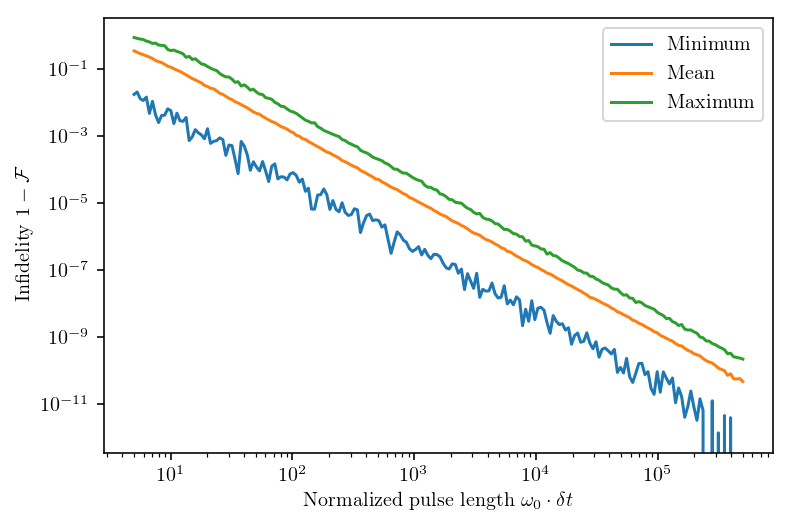

In [69]:
plt.figure(figsize=(6,4))
plt.loglog()
plt.plot(dTlist, 1 - np.array(maxes), label="Minimum")
plt.plot(dTlist, 1 - np.array(means), label="Mean")
plt.plot(dTlist, 1 - np.array(mins), label="Maximum")
plt.legend()
plt.ylabel("Infidelity $1-\mathcal{F}$")
plt.xlabel("Normalized pulse length $\omega_0 \cdot \delta t$")
plt.savefig("assets/mzi_fidelities.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()